In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/5g-nidd-dataset/Combined.csv


In [17]:
!pip install fancyimpute

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import requests, zipfile, io
import missingno as msno
import sklearn
import fancyimpute

In [19]:
# input_path = '/kaggle/input/5g-nidd-dataset'
# output_path = '/kaggle/temp/5g-nidd-dataset'
# # Copy dataset into working directory
# shutil.copytree(input_path, output_path)

In [20]:
cd /kaggle/temp/5g-nidd-dataset

/kaggle/temp/5g-nidd-dataset


In [21]:
df = pd.read_csv('Combined.csv', low_memory=False)
df.describe()

,Unnamed: 0,Seq,Dur,RunTime,Mean,Sum,Min,Max,sTos,dTos,...,DstRate,SrcWin,DstWin,sVid,dVid,SrcTCPBase,DstTCPBase,TcpRtt,SynAck,AckDat
count,1215890.000000,1215890.000000,1215890.000000,1215890.000000,1215890.000000,1215890.000000,1215890.000000,1215890.000000,1215676.000000,272823.000000,...,1215890.000000,242420.000000,177078.000000,114571.000000,2009.000000,278671.000000,230047.000000,1215890.000000,1215890.000000,1215890.000000
mean,315888.520114,40343.336930,1.364841,1.364841,1.364841,1.364841,1.364841,1.364841,0.864382,2.637593,...,499.966154,914968.879474,69513.358164,610.000000,610.000000,2044247683.019428,2146304531.597617,0.004670,0.000582,0.004088
std,194685.327627,37772.012502,1.691295,1.691295,1.691295,1.691295,1.691295,1.691295,12.518954,21.037454,...,56573.290204,4991475.670881,202116.364533,0.000000,0.000000,1233429312.640444,1243342448.155103,0.017428,0.013056,0.010536
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,610.000000,610.000000,123073.000000,33089.000000,0.000000,0.000000,0.000000
25%,151986.000000,8861.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,56576.000000,64768.000000,610.000000,610.000000,986247487.000000,1070928503.000000,0.000000,0.000000,0.000000
50%,303972.000000,27223.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,62592.000000,64896.000000,610.000000,610.000000,1994167345.000000,2151747461.000000,0.000000,0.000000,0.000000
75%,455958.000000,63316.000000,2.580399,2.580399,2.580399,2.580399,2.580399,2.580399,0.000000,0.000000,...,0.000000,64256.000000,65024.000000,610.000000,610.000000,3093609023.500000,3224407820.000000,0.000000,0.000000,0.000000
max,728315.000000,137210.000000,19.920630,19.920630,19.920630,19.920630,19.920630,19.920630,224.000000,186.000000,...,26000000.000000,33553920.000000,16776960.000000,610.000000,610.000000,4294967295.000000,4294956058.000000,1.051236,1.024680,0.266729


In [22]:
pd.set_option('float_format', '{:f}'.format)
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["xtick.labelsize"] = 7
pd.set_option('future.no_silent_downcasting', True)

In [23]:
from fancyimpute import IterativeImputer

# Define a function to impute NaN values with the most frequent value in the group
def impute_most_frequent(group):
    mode_value = group.mode().iloc[0] if not group.mode().empty else np.nan
    return group.fillna(mode_value)

def handle_missing_values(df):
    df.drop_duplicates(inplace=True)
    df.drop(['sVid', 'dVid'], axis=1, inplace=True)
    df.dropna(subset=['sTos', 'sHops', 'sTtl', 'sDSb'], how='any', inplace=True)
    df[['dTtl', 'dDSb', 'dTos', 'dHops', 'SrcGap', 'DstGap']] = df.groupby('Attack Type')[['dTtl', 'dDSb', 'dTos', 'dHops', 'SrcGap', 'DstGap']].transform(impute_most_frequent)
    df['dDSb'] = df['dDSb'].fillna('cs0')
    
    df_subset_copy = df[['dTtl', 'dTos', 'dHops', 'SrcGap', 'DstGap', 'SrcTCPBase', 'DstTCPBase', 'SrcWin', 'DstWin']].copy(deep=True)
    mice_imputer = IterativeImputer()
    df_subset_copy.iloc[:, :] = mice_imputer.fit_transform(df_subset_copy)
    df[['dTtl', 'dTos', 'dHops', 'SrcGap', 'DstGap', 'SrcTCPBase', 'DstTCPBase', 'SrcWin', 'DstWin']] = df_subset_copy
    
handle_missing_values(df)
df.isna().any()

Unnamed: 0     False
Seq            False
Dur            False
RunTime        False
Mean           False
Sum            False
Min            False
Max            False
Proto          False
sTos           False
dTos           False
sDSb           False
dDSb           False
sTtl           False
dTtl           False
sHops          False
dHops          False
Cause          False
TotPkts        False
SrcPkts        False
DstPkts        False
TotBytes       False
SrcBytes       False
DstBytes       False
Offset         False
sMeanPktSz     False
dMeanPktSz     False
Load           False
SrcLoad        False
DstLoad        False
Loss           False
SrcLoss        False
DstLoss        False
pLoss          False
SrcGap         False
DstGap         False
Rate           False
SrcRate        False
DstRate        False
State          False
SrcWin         False
DstWin         False
SrcTCPBase     False
DstTCPBase     False
TcpRtt         False
SynAck         False
AckDat         False
Label        

In [41]:
def view_numeric_columns_distribution(i, col):
    seventy_fifth = df[col].quantile(0.75)
    twenty_fifth = df[col].quantile(0.25)
    iqr = seventy_fifth - twenty_fifth
    upper = seventy_fifth + 1.5*iqr
    lower = twenty_fifth - 1.5*iqr   
    outliers = df[(df[col] < lower) | (df[col] > upper)][[col, 'Attack Type']]
    if outliers.size > 0:
        print(f"Column {i} name: {col} \n")
        print(f"Column dtype: {df[col].dtype} \n")
        print(f"Value Description: \n\n{df[col].describe()} \n")    
        
        sns.boxplot(data = df, y=col)
        plt.show()
        
        print(f"75th %ile {seventy_fifth}, Col name: {col} \n") 
        print(f"25th %ile {twenty_fifth}, Col name: {col} \n")
        print(f"IQR {iqr}, Col name: {col} \n")
        print(f"Upper limit {upper}, Col name: {col} \n")    
        print(f"Lower limit {lower}, Col name: {col} \n")   
        print(f"outliers size: {outliers.size} \n")        
        print(outliers[col].describe())    
        
        print(f"\noutliers - Attack Type counts: {outliers['Attack Type'].value_counts()}  \n")       
        print('\n--------------------------------------------------------------\n')
        print('\n--------------------------------------------------------------\n')    

Column 3 name: Dur 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          1.365063
std           1.691351
min           0.000000
25%           0.000000
50%           0.000000
75%           2.580405
max          19.920630
Name: Dur, dtype: float64 



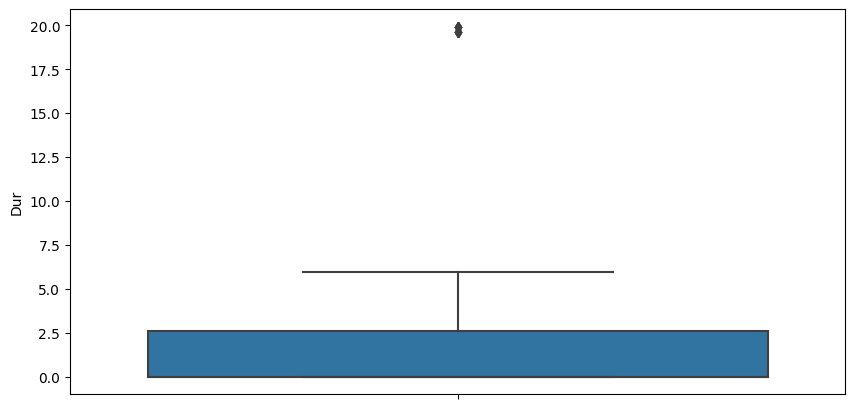

75th %ile 2.580405, Col name: Dur 

25th %ile 0.0, Col name: Dur 

IQR 2.580405, Col name: Dur 

Upper limit 6.451012499999999, Col name: Dur 

Lower limit -3.8706074999999998, Col name: Dur 

outliers size: 28 

count   14.000000
mean    19.747022
std      0.152222
min     19.608786
25%     19.622501
50%     19.630265
75%     19.914848
max     19.920630
Name: Dur, dtype: float64

outliers - Attack Type counts: Attack Type
Benign    14
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 4 name: RunTime 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          1.365063
std           1.691351
min           0.000000
25%           0.000000
50%           0.000000
75%           2.580405
max          19.920630
Name: RunTime, dtype: float64 



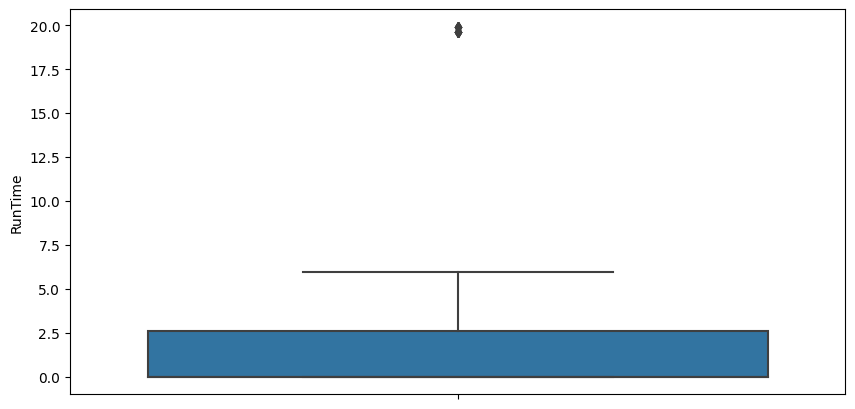

75th %ile 2.580405, Col name: RunTime 

25th %ile 0.0, Col name: RunTime 

IQR 2.580405, Col name: RunTime 

Upper limit 6.451012499999999, Col name: RunTime 

Lower limit -3.8706074999999998, Col name: RunTime 

outliers size: 28 

count   14.000000
mean    19.747022
std      0.152222
min     19.608786
25%     19.622501
50%     19.630265
75%     19.914848
max     19.920630
Name: RunTime, dtype: float64

outliers - Attack Type counts: Attack Type
Benign    14
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 5 name: Mean 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          1.365063
std           1.691351
min           0.000000
25%           0.000000
50%           0.000000
75%           2.580405
max          19.920630
Name: Mean, dtype: float64 



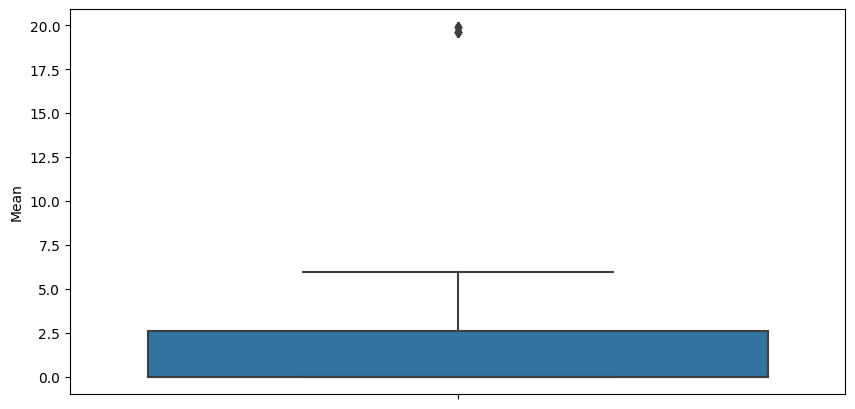

75th %ile 2.580405, Col name: Mean 

25th %ile 0.0, Col name: Mean 

IQR 2.580405, Col name: Mean 

Upper limit 6.451012499999999, Col name: Mean 

Lower limit -3.8706074999999998, Col name: Mean 

outliers size: 28 

count   14.000000
mean    19.747022
std      0.152222
min     19.608786
25%     19.622501
50%     19.630265
75%     19.914848
max     19.920630
Name: Mean, dtype: float64

outliers - Attack Type counts: Attack Type
Benign    14
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 6 name: Sum 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          1.365063
std           1.691351
min           0.000000
25%           0.000000
50%           0.000000
75%           2.580405
max          19.920630
Name: Sum, dtype: float64 



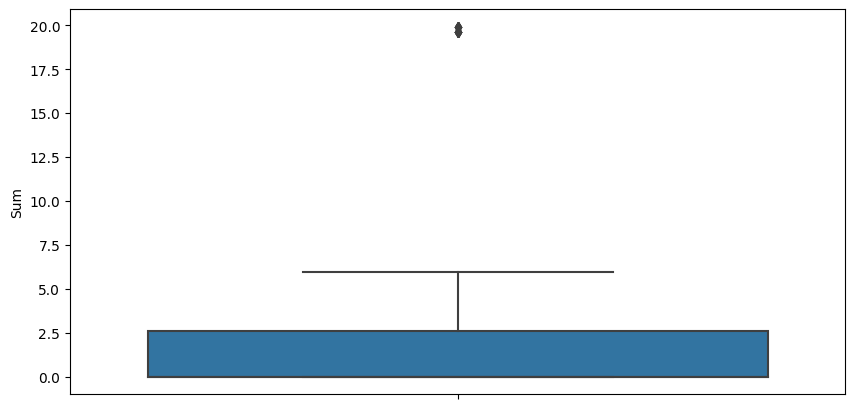

75th %ile 2.580405, Col name: Sum 

25th %ile 0.0, Col name: Sum 

IQR 2.580405, Col name: Sum 

Upper limit 6.451012499999999, Col name: Sum 

Lower limit -3.8706074999999998, Col name: Sum 

outliers size: 28 

count   14.000000
mean    19.747022
std      0.152222
min     19.608786
25%     19.622501
50%     19.630265
75%     19.914848
max     19.920630
Name: Sum, dtype: float64

outliers - Attack Type counts: Attack Type
Benign    14
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 7 name: Min 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          1.365063
std           1.691351
min           0.000000
25%           0.000000
50%           0.000000
75%           2.580405
max          19.920630
Name: Min, dtype: float64 



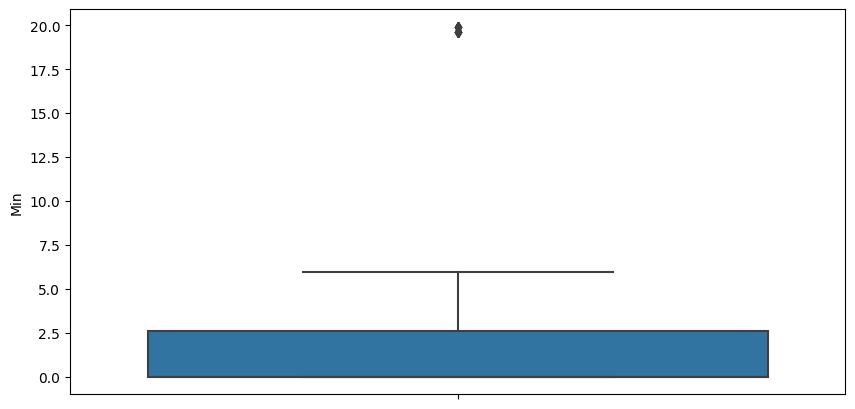

75th %ile 2.580405, Col name: Min 

25th %ile 0.0, Col name: Min 

IQR 2.580405, Col name: Min 

Upper limit 6.451012499999999, Col name: Min 

Lower limit -3.8706074999999998, Col name: Min 

outliers size: 28 

count   14.000000
mean    19.747022
std      0.152222
min     19.608786
25%     19.622501
50%     19.630265
75%     19.914848
max     19.920630
Name: Min, dtype: float64

outliers - Attack Type counts: Attack Type
Benign    14
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 8 name: Max 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          1.365063
std           1.691351
min           0.000000
25%           0.000000
50%           0.000000
75%           2.580405
max          19.920630
Name: Max, dtype: float64 



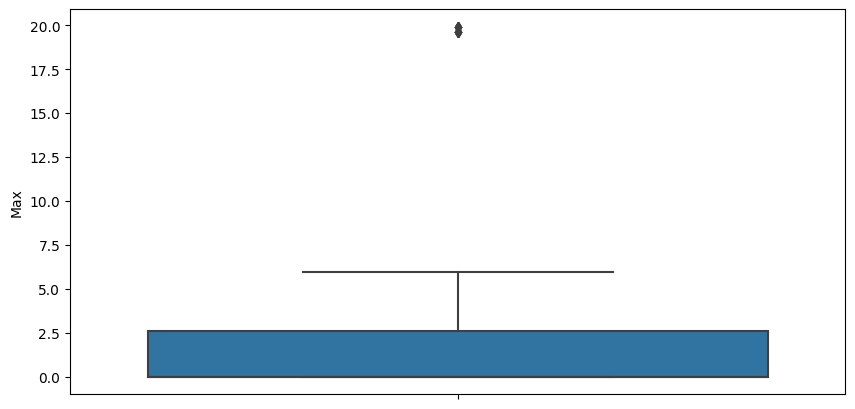

75th %ile 2.580405, Col name: Max 

25th %ile 0.0, Col name: Max 

IQR 2.580405, Col name: Max 

Upper limit 6.451012499999999, Col name: Max 

Lower limit -3.8706074999999998, Col name: Max 

outliers size: 28 

count   14.000000
mean    19.747022
std      0.152222
min     19.608786
25%     19.622501
50%     19.630265
75%     19.914848
max     19.920630
Name: Max, dtype: float64

outliers - Attack Type counts: Attack Type
Benign    14
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 9 name: sTos 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          0.864383
std          12.518959
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         224.000000
Name: sTos, dtype: float64 



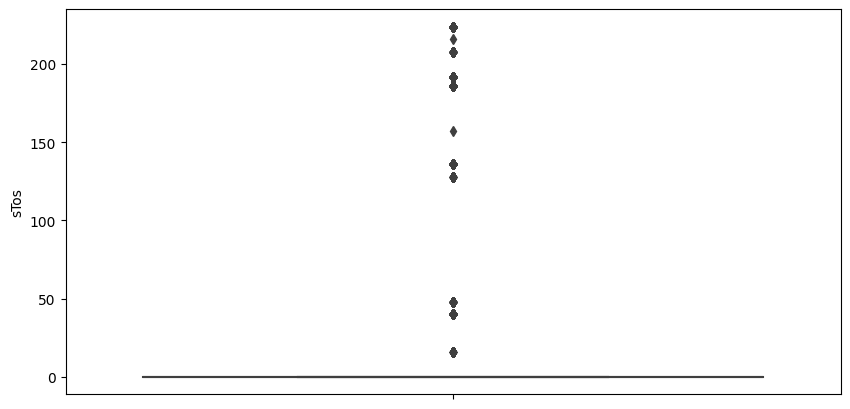

75th %ile 0.0, Col name: sTos 

25th %ile 0.0, Col name: sTos 

IQR 0.0, Col name: sTos 

Upper limit 0.0, Col name: sTos 

Lower limit 0.0, Col name: sTos 

outliers size: 12920 

count   6460.000000
mean     162.663932
std       56.344325
min       16.000000
25%      186.000000
50%      186.000000
75%      186.000000
max      224.000000
Name: sTos, dtype: float64

outliers - Attack Type counts: Attack Type
Benign    6460
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 10 name: dTos 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          0.948916
std          10.016102
min           0.000000
25%           0.000000
50%           0.000000
75%           0.948916
max         186.000000
Name: dTos, dtype: float64 



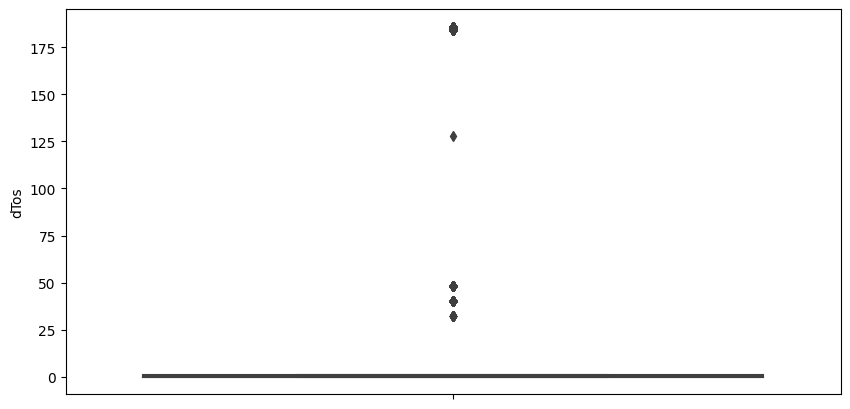

75th %ile 0.9489157166687647, Col name: dTos 

25th %ile 0.0, Col name: dTos 

IQR 0.9489157166687647, Col name: dTos 

Upper limit 2.372289291671912, Col name: dTos 

Lower limit -1.423373575003147, Col name: dTos 

outliers size: 10600 

count   5300.000000
mean     135.772830
std       68.604936
min       32.000000
25%       40.000000
50%      186.000000
75%      186.000000
max      186.000000
Name: dTos, dtype: float64

outliers - Attack Type counts: Attack Type
Benign    5300
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 11 name: sTtl 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean         81.454487
std          55.926746
min          36.000000
25%          63.000000
50%          63.000000
75%          63.000000
max         255.000000
Name: sTtl, dtype: float64 



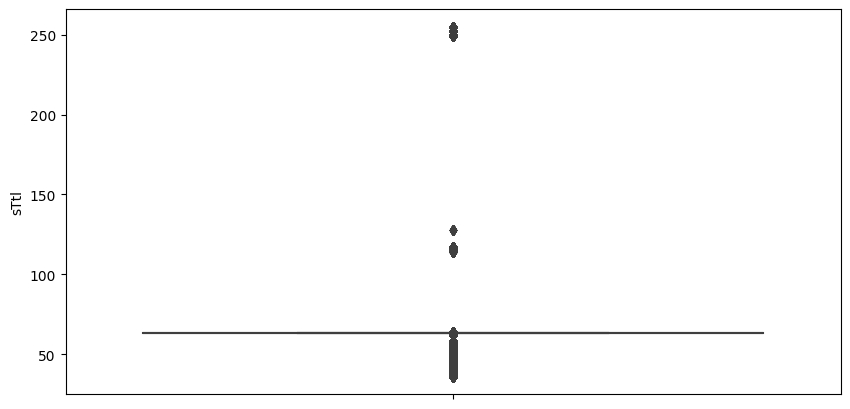

75th %ile 63.0, Col name: sTtl 

25th %ile 63.0, Col name: sTtl 

IQR 0.0, Col name: sTtl 

Upper limit 63.0, Col name: sTtl 

Lower limit 63.0, Col name: sTtl 

outliers size: 469266 

count   234633.000000
mean       158.615958
std         93.956615
min         36.000000
25%         58.000000
50%        249.000000
75%        249.000000
max        255.000000
Name: sTtl, dtype: float64

outliers - Attack Type counts: Attack Type
Benign            195794
SYNScan            20021
UDPScan            15906
SYNFlood            2871
TCPConnectScan        41
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 12 name: dTtl 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean         64.097845
std          13.366518
min          37.000000
25%          64.000000
50%          64.000000
75%          64.097845
max         255.000000
Name: dTtl, dtype: float64 



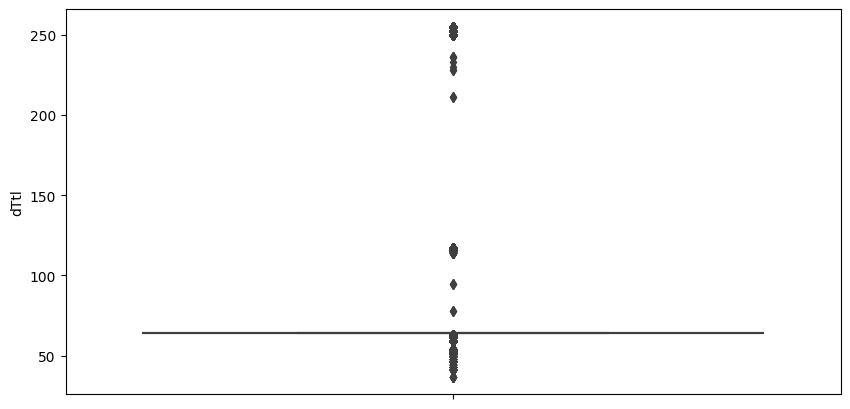

75th %ile 64.0978446201242, Col name: dTtl 

25th %ile 64.0, Col name: dTtl 

IQR 0.09784462012420647, Col name: dTtl 

Upper limit 64.24461155031051, Col name: dTtl 

Lower limit 63.85323306981369, Col name: dTtl 

outliers size: 620292 

count   310146.000000
mean        64.239239
std         26.462690
min         37.000000
25%         59.000000
50%         59.000000
75%         59.000000
max        255.000000
Name: dTtl, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         140812
SlowrateDoS        73124
Benign             29333
TCPConnectScan     20052
SYNScan            20043
UDPScan            15906
SYNFlood            9721
ICMPFlood           1155
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 13 name: sHops 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          2.257097
std           3.564295
min           0.

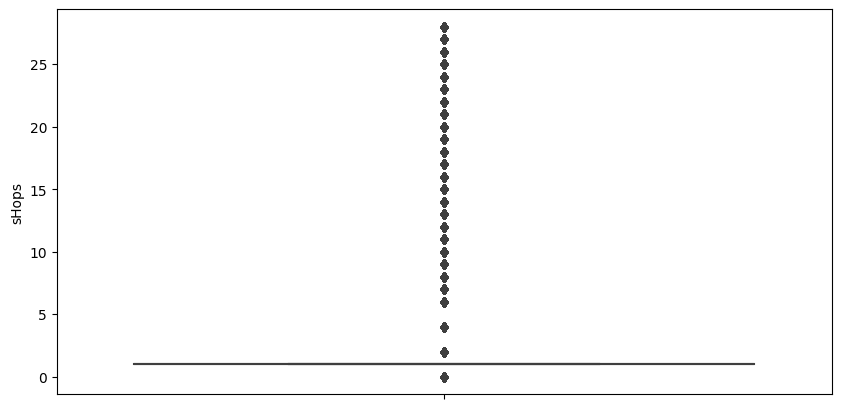

75th %ile 1.0, Col name: sHops 

25th %ile 1.0, Col name: sHops 

IQR 0.0, Col name: sHops 

Upper limit 1.0, Col name: sHops 

Lower limit 1.0, Col name: sHops 

outliers size: 458648 

count   229324.000000
mean         7.664026
std          5.595955
min          0.000000
25%          6.000000
50%          7.000000
75%          7.000000
max         28.000000
Name: sHops, dtype: float64

outliers - Attack Type counts: Attack Type
Benign            190490
SYNScan            20021
UDPScan            15906
SYNFlood            2866
TCPConnectScan        41
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 14 name: dHops 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          2.185895
std           2.246418
min           0.000000
25%           0.000000
50%           2.185895
75%           2.185895
max          50.000000
Name: dHops, dtype: float64 

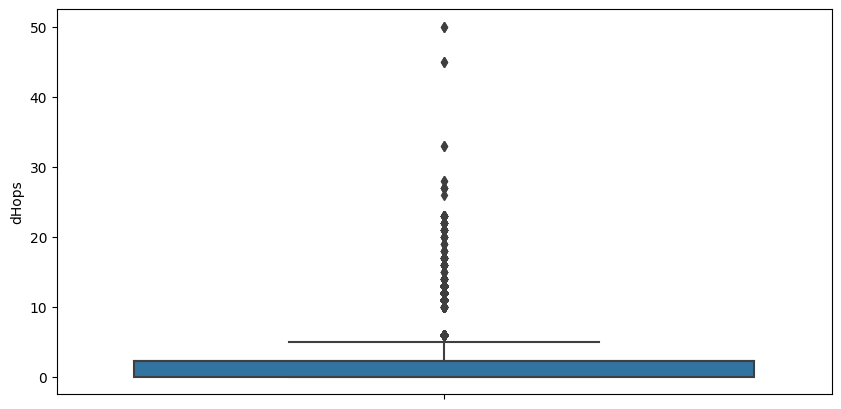

75th %ile 2.1858954156137744, Col name: dHops 

25th %ile 0.0, Col name: dHops 

IQR 2.1858954156137744, Col name: dHops 

Upper limit 5.464738539034435, Col name: dHops 

Lower limit -3.2788431234206614, Col name: dHops 

outliers size: 44232 

count   22116.000000
mean       10.958039
std         1.638711
min         6.000000
25%        11.000000
50%        11.000000
75%        11.000000
max        50.000000
Name: dHops, dtype: float64

outliers - Attack Type counts: Attack Type
Benign    22116
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 15 name: TotPkts 

Column dtype: int64 

Value Description: 

count   1215675.000000
mean          5.145593
std          24.822249
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max        3997.000000
Name: TotPkts, dtype: float64 



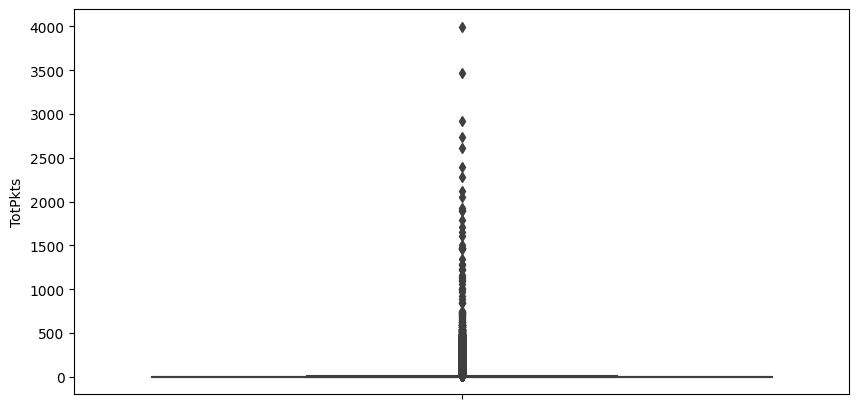

75th %ile 2.0, Col name: TotPkts 

25th %ile 1.0, Col name: TotPkts 

IQR 1.0, Col name: TotPkts 

Upper limit 3.5, Col name: TotPkts 

Lower limit -0.5, Col name: TotPkts 

outliers size: 314316 

count   157158.000000
mean        29.868559
std         63.732896
min          4.000000
25%          7.000000
50%         11.000000
75%         19.000000
max       3997.000000
Name: TotPkts, dtype: float64

outliers - Attack Type counts: Attack Type
SlowrateDoS       63594
HTTPFlood         54303
Benign            39193
TCPConnectScan       61
SYNFlood              7
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 16 name: SrcPkts 

Column dtype: int64 

Value Description: 

count   1215675.000000
mean          3.701233
std          18.413796
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         986.000000
Name: SrcPkts, dtype

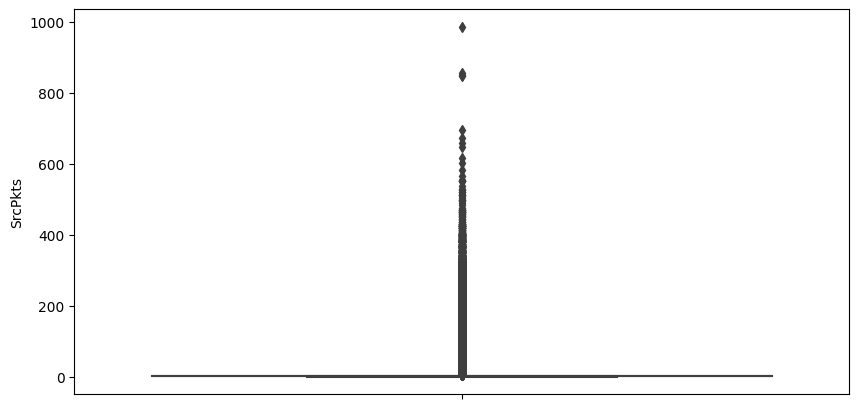

75th %ile 2.0, Col name: SrcPkts 

25th %ile 1.0, Col name: SrcPkts 

IQR 1.0, Col name: SrcPkts 

Upper limit 3.5, Col name: SrcPkts 

Lower limit -0.5, Col name: SrcPkts 

outliers size: 244072 

count   122036.000000
mean        24.137394
std         53.941678
min          4.000000
25%          5.000000
50%          7.000000
75%          9.000000
max        986.000000
Name: SrcPkts, dtype: float64

outliers - Attack Type counts: Attack Type
SlowrateDoS    46654
HTTPFlood      45237
Benign         30145
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 17 name: DstPkts 

Column dtype: int64 

Value Description: 

count   1215675.000000
mean          1.444360
std          12.466852
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        3151.000000
Name: DstPkts, dtype: float64 



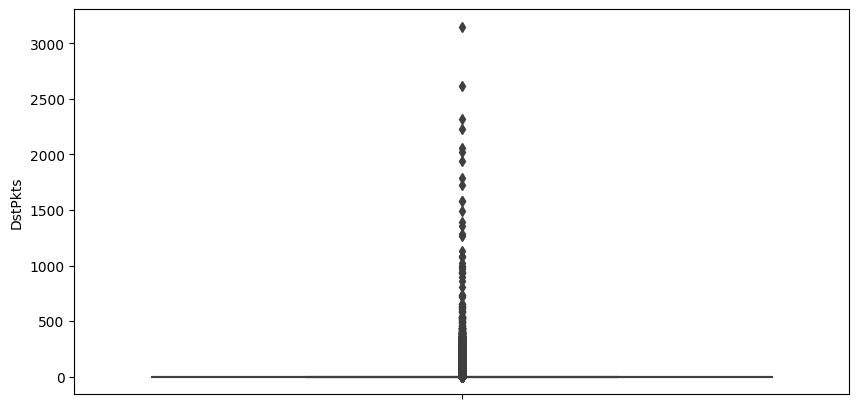

75th %ile 0.0, Col name: DstPkts 

25th %ile 0.0, Col name: DstPkts 

IQR 0.0, Col name: DstPkts 

Upper limit 0.0, Col name: DstPkts 

Lower limit 0.0, Col name: DstPkts 

outliers size: 511586 

count   255793.000000
mean         6.864426
std         26.484956
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
max       3151.000000
Name: DstPkts, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         124041
SlowrateDoS        72919
Benign             49130
SYNFlood            8336
ICMPFlood           1154
TCPConnectScan        91
SYNScan               83
UDPScan               39
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 18 name: TotBytes 

Column dtype: int64 

Value Description: 

count   1215675.000000
mean       3647.505899
std       30185.225858
min          42.000000
25%          42.000000
50%      

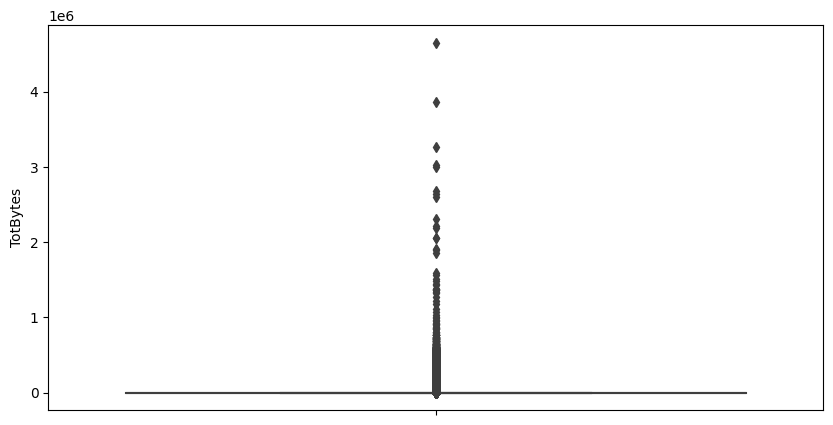

75th %ile 84.0, Col name: TotBytes 

25th %ile 42.0, Col name: TotBytes 

IQR 42.0, Col name: TotBytes 

Upper limit 147.0, Col name: TotBytes 

Lower limit -21.0, Col name: TotBytes 

outliers size: 375942 

count    187971.000000
mean      23209.759458
std       73756.767656
min         148.000000
25%         532.000000
50%        1095.000000
75%       12541.000000
max     4656256.000000
Name: TotBytes, dtype: float64

outliers - Attack Type counts: Attack Type
SlowrateDoS       66632
HTTPFlood         56601
Benign            56198
SYNFlood           8336
TCPConnectScan      167
SYNScan              22
UDPScan              15
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 19 name: SrcBytes 

Column dtype: int64 

Value Description: 

count   1215675.000000
mean       2533.108184
std       24467.905904
min           0.000000
25%          42.000000
50%          74.0000

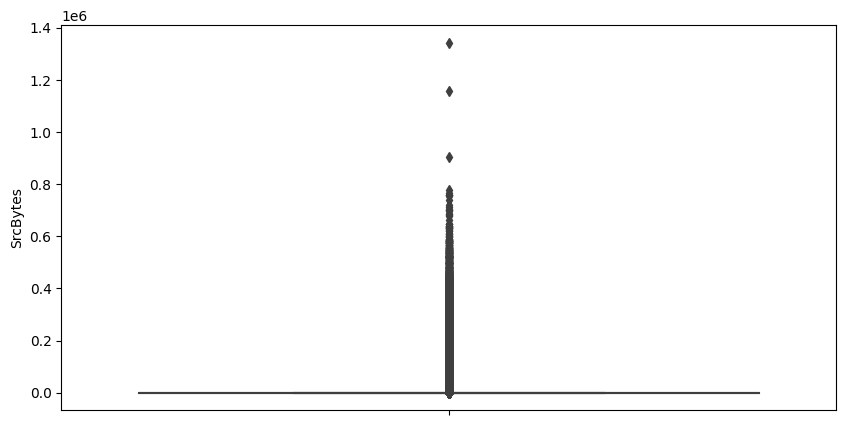

75th %ile 84.0, Col name: SrcBytes 

25th %ile 42.0, Col name: SrcBytes 

IQR 42.0, Col name: SrcBytes 

Upper limit 147.0, Col name: SrcBytes 

Lower limit -21.0, Col name: SrcBytes 

outliers size: 318048 

count    159024.000000
mean      18927.861549
std       65325.617089
min         148.000000
25%         335.000000
50%         660.000000
75%         980.000000
max     1343477.000000
Name: SrcBytes, dtype: float64

outliers - Attack Type counts: Attack Type
SlowrateDoS       59592
HTTPFlood         52345
Benign            46905
TCPConnectScan      167
UDPScan              15
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 20 name: DstBytes 

Column dtype: int64 

Value Description: 

count   1215675.000000
mean       1114.397715
std       16786.128259
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max     4551675.000000

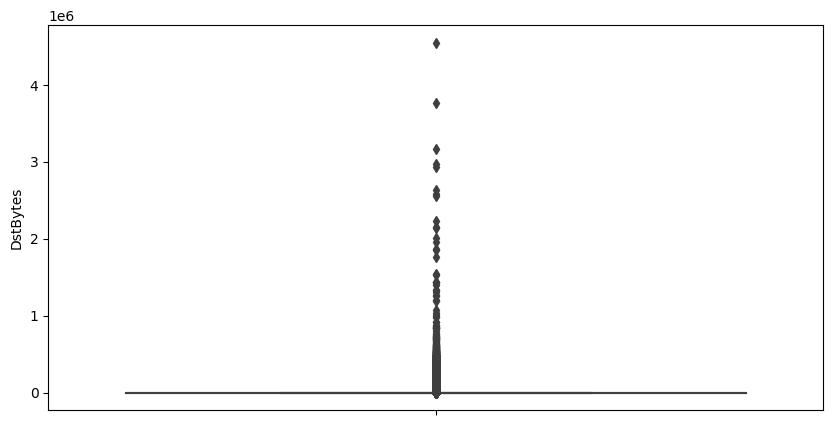

75th %ile 0.0, Col name: DstBytes 

25th %ile 0.0, Col name: DstBytes 

IQR 0.0, Col name: DstBytes 

Upper limit 0.0, Col name: DstBytes 

Lower limit 0.0, Col name: DstBytes 

outliers size: 511586 

count    255793.000000
mean       5296.256903
std       36290.604014
min          42.000000
25%          66.000000
50%         206.000000
75%        3815.000000
max     4551675.000000
Name: DstBytes, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         124041
SlowrateDoS        72919
Benign             49130
SYNFlood            8336
ICMPFlood           1154
TCPConnectScan        91
SYNScan               83
UDPScan               39
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 22 name: sMeanPktSz 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean         74.012443
std         145.679309
min           0.000000
25%          4

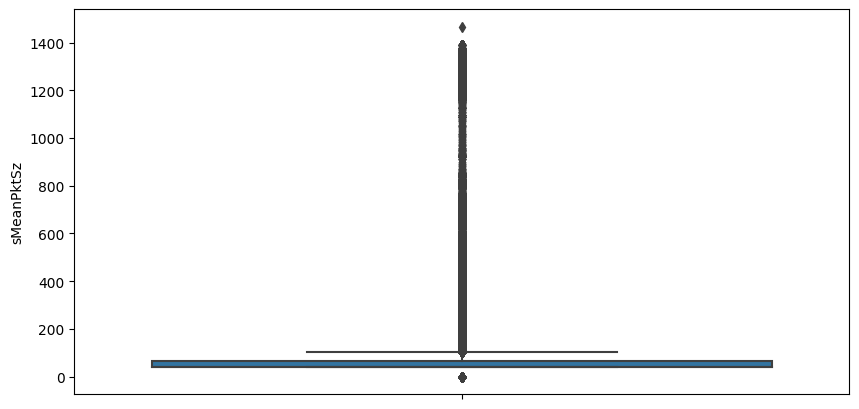

75th %ile 67.0, Col name: sMeanPktSz 

25th %ile 42.0, Col name: sMeanPktSz 

IQR 25.0, Col name: sMeanPktSz 

Upper limit 104.5, Col name: sMeanPktSz 

Lower limit 4.5, Col name: sMeanPktSz 

outliers size: 256522 

count   128261.000000
mean       264.887209
std        397.929721
min          0.000000
25%          0.000000
50%        123.250000
75%        194.250000
max       1467.000000
Name: sMeanPktSz, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood      73957
Benign         38019
SlowrateDoS    16238
UDPScan           47
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 23 name: dMeanPktSz 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean         61.901989
std         215.098414
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1478.000000
Name: dMeanPktSz, dtype: floa

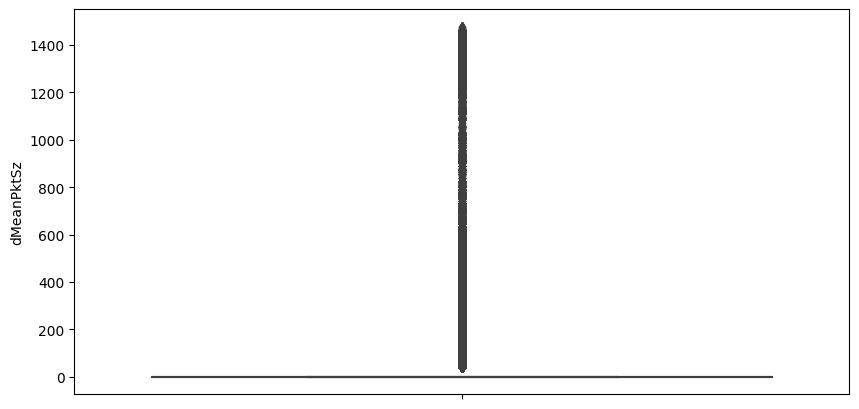

75th %ile 0.0, Col name: dMeanPktSz 

25th %ile 0.0, Col name: dMeanPktSz 

IQR 0.0, Col name: dMeanPktSz 

Upper limit 0.0, Col name: dMeanPktSz 

Lower limit 0.0, Col name: dMeanPktSz 

outliers size: 511586 

count   255793.000000
mean       294.193743
std        389.294876
min         42.000000
25%         66.000000
50%         67.599998
75%        306.000000
max       1478.000000
Name: dMeanPktSz, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         124041
SlowrateDoS        72919
Benign             49130
SYNFlood            8336
ICMPFlood           1154
TCPConnectScan        91
SYNScan               83
UDPScan               39
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 24 name: Load 

Column dtype: float64 

Value Description: 

count        1215675.000000
mean         4929798.815701
std        594630446.456145
min                0.000

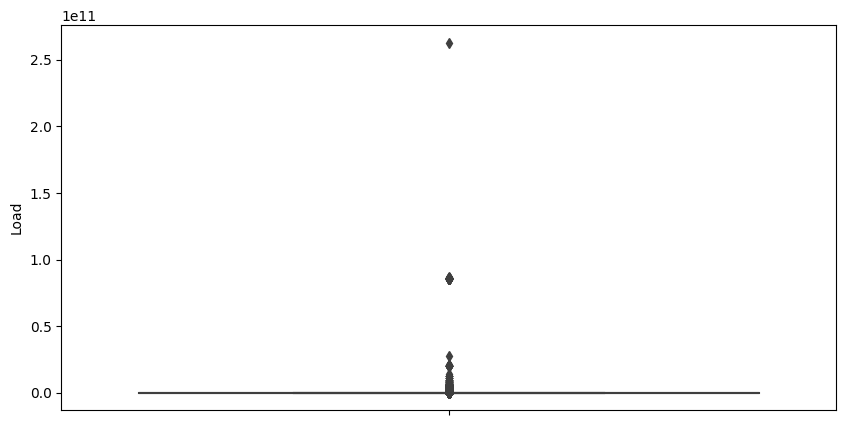

75th %ile 130.518784, Col name: Load 

25th %ile 0.0, Col name: Load 

IQR 130.518784, Col name: Load 

Upper limit 326.29696, Col name: Load 

Lower limit -195.77817600000003, Col name: Load 

outliers size: 343306 

count         171653.000000
mean        34913359.417047
std       1582123852.370148
min              326.444214
25%             1772.364380
50%            12289.719730
75%            64046.195310
max     263000000000.000000
Name: Load, dtype: float64

outliers - Attack Type counts: Attack Type
SlowrateDoS       65999
HTTPFlood         55264
Benign            41866
SYNFlood           8335
TCPConnectScan      167
SYNScan              22
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 25 name: SrcLoad 

Column dtype: float64 

Value Description: 

count      1215675.000000
mean        139391.900526
std       13083442.571503
min              0.000000
25%      

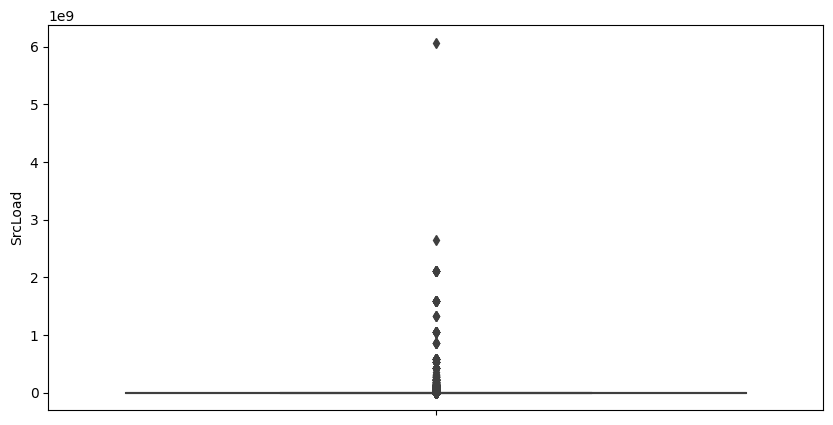

75th %ile 130.492691, Col name: SrcLoad 

25th %ile 0.0, Col name: SrcLoad 

IQR 130.492691, Col name: SrcLoad 

Upper limit 326.23172750000003, Col name: SrcLoad 

Lower limit -195.7390365, Col name: SrcLoad 

outliers size: 309204 

count       154602.000000
mean       1095727.220636
std       36673751.427046
min            326.239380
25%            842.769271
50%           1566.203309
75%          46412.709962
max     6072000000.000000
Name: SrcLoad, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         52587
SlowrateDoS       52131
Benign            41360
SYNFlood           8335
TCPConnectScan      167
SYNScan              22
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 26 name: DstLoad 

Column dtype: float64 

Value Description: 

count        1215675.000000
mean         4790841.370587
std        584761212.015216
min                0.0000

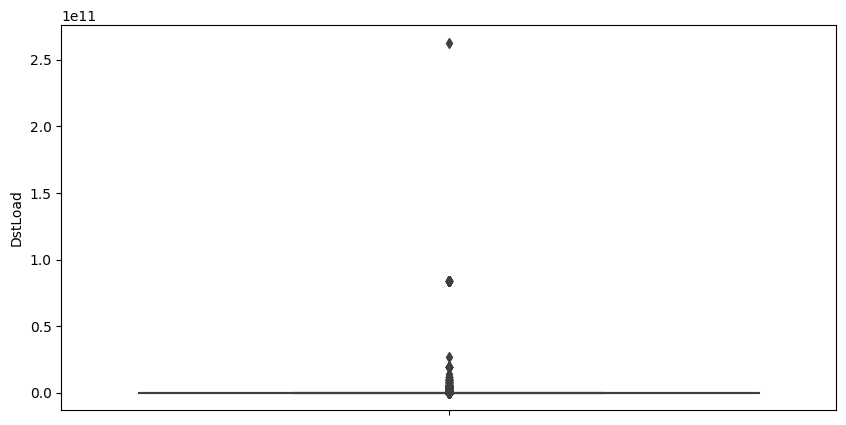

75th %ile 0.0, Col name: DstLoad 

25th %ile 0.0, Col name: DstLoad 

IQR 0.0, Col name: DstLoad 

Upper limit 0.0, Col name: DstLoad 

Lower limit 0.0, Col name: DstLoad 

outliers size: 316098 

count         158049.000000
mean        36850002.740849
std       1621418270.366270
min              101.196930
25%              746.732971
50%             5904.788574
75%            19729.150390
max     263000000000.000000
Name: DstLoad, dtype: float64

outliers - Attack Type counts: Attack Type
SlowrateDoS    66548
HTTPFlood      53675
Benign         37819
SYNFlood           7
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 27 name: Loss 

Column dtype: int64 

Value Description: 

count   1215675.000000
mean          0.022879
std           0.247967
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          28.000000
Name: Loss, 

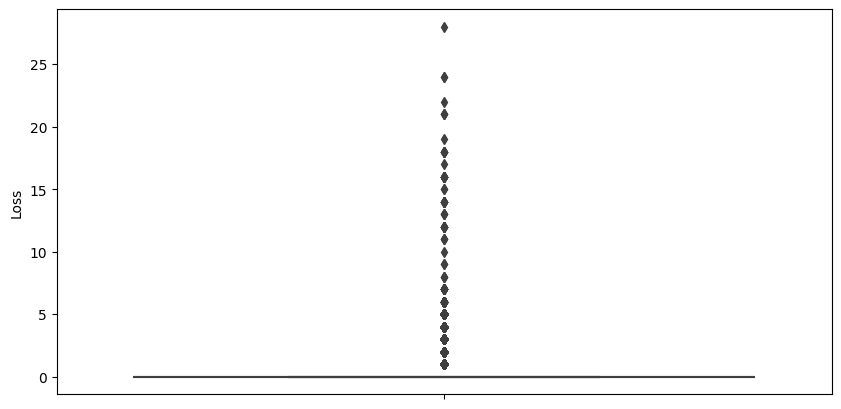

75th %ile 0.0, Col name: Loss 

25th %ile 0.0, Col name: Loss 

IQR 0.0, Col name: Loss 

Upper limit 0.0, Col name: Loss 

Lower limit 0.0, Col name: Loss 

outliers size: 32516 

count   16258.000000
mean        1.710727
std         1.307789
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        28.000000
Name: Loss, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         8699
Benign            7018
SlowrateDoS        370
TCPConnectScan     106
SYNFlood            65
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 28 name: SrcLoss 

Column dtype: int64 

Value Description: 

count   1215675.000000
mean          0.013240
std           0.176658
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: SrcLoss, dtype: float64 



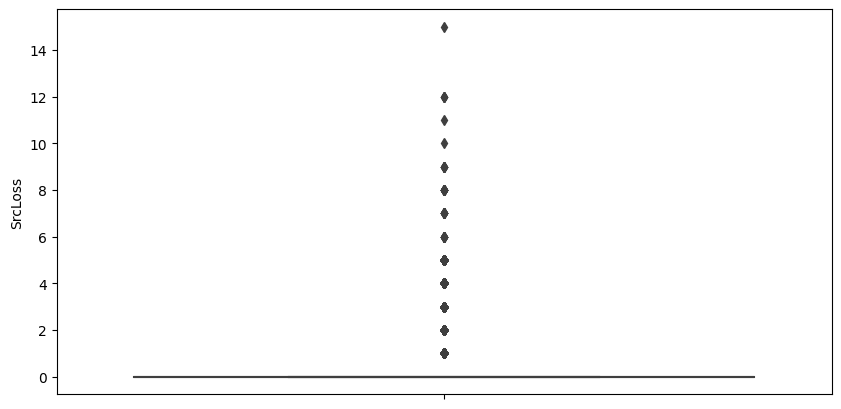

75th %ile 0.0, Col name: SrcLoss 

25th %ile 0.0, Col name: SrcLoss 

IQR 0.0, Col name: SrcLoss 

Upper limit 0.0, Col name: SrcLoss 

Lower limit 0.0, Col name: SrcLoss 

outliers size: 18680 

count   9340.000000
mean       1.723340
std        1.055942
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       15.000000
Name: SrcLoss, dtype: float64

outliers - Attack Type counts: Attack Type
Benign            6914
HTTPFlood         2044
SlowrateDoS        218
TCPConnectScan     106
SYNFlood            58
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 29 name: DstLoss 

Column dtype: int64 

Value Description: 

count   1215675.000000
mean          0.009646
std           0.155903
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.000000
Name: DstLoss, dtype: float64 



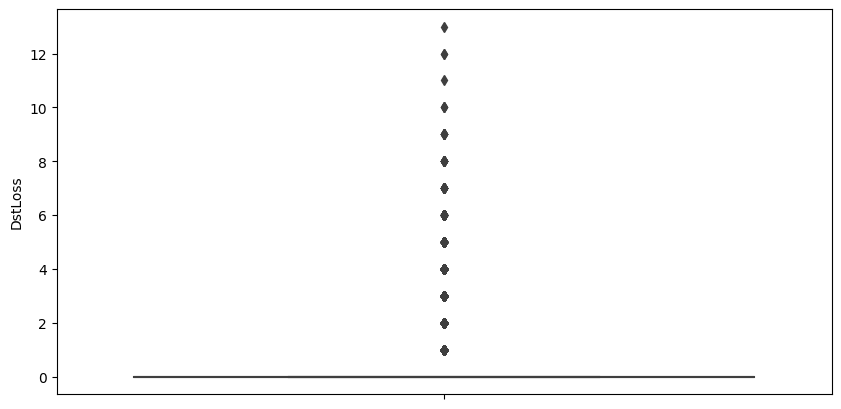

75th %ile 0.0, Col name: DstLoss 

25th %ile 0.0, Col name: DstLoss 

IQR 0.0, Col name: DstLoss 

Upper limit 0.0, Col name: DstLoss 

Lower limit 0.0, Col name: DstLoss 

outliers size: 14164 

count   7082.000000
mean       1.655888
std        1.202690
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       13.000000
Name: DstLoss, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood      6676
Benign          207
SlowrateDoS     192
SYNFlood          7
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 30 name: pLoss 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          0.349553
std           3.672335
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          62.500000
Name: pLoss, dtype: float64 



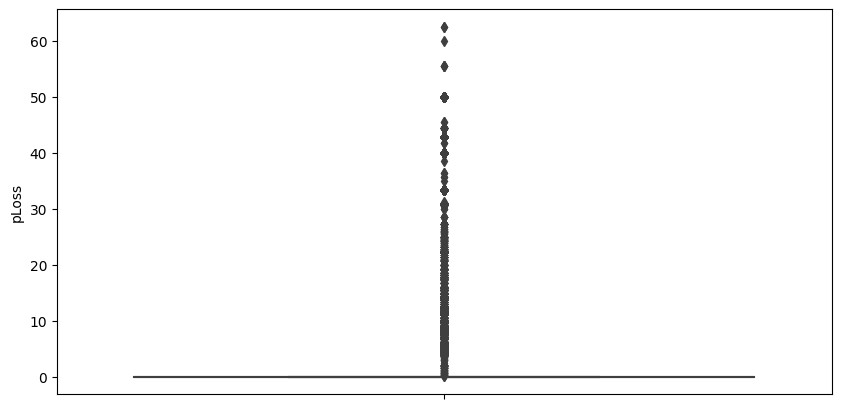

75th %ile 0.0, Col name: pLoss 

25th %ile 0.0, Col name: pLoss 

IQR 0.0, Col name: pLoss 

Upper limit 0.0, Col name: pLoss 

Lower limit 0.0, Col name: pLoss 

outliers size: 32516 

count   16258.000000
mean       26.137445
std        18.286470
min         0.116959
25%         8.333333
50%        22.222222
75%        50.000000
max        62.500000
Name: pLoss, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         8699
Benign            7018
SlowrateDoS        370
TCPConnectScan     106
SYNFlood            65
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 31 name: SrcGap 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          0.019287
std           5.035320
min           0.000000
25%           0.000000
50%           0.000000
75%           0.019287
max        3064.000000
Name: SrcGap, dtype: float64 



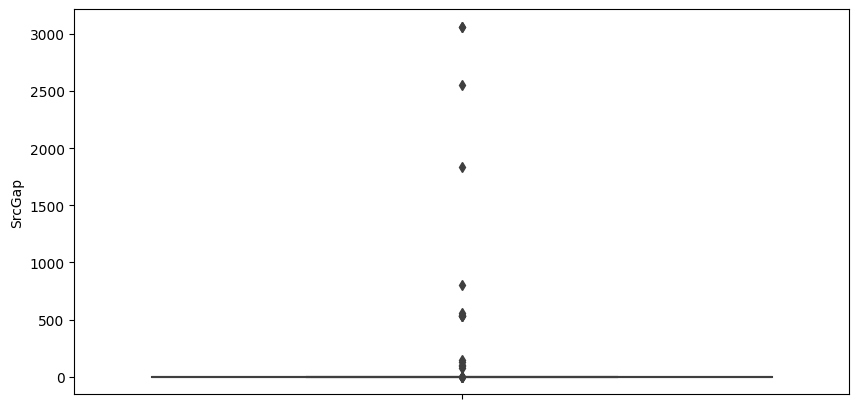

75th %ile 0.019286509524586992, Col name: SrcGap 

25th %ile 0.0, Col name: SrcGap 

IQR 0.019286509524586992, Col name: SrcGap 

Upper limit 0.04821627381146748, Col name: SrcGap 

Lower limit -0.02892976428688049, Col name: SrcGap 

outliers size: 42 

count     21.000000
mean     693.857143
std     1017.664694
min        1.000000
25%        1.000000
50%      145.000000
75%      560.000000
max     3064.000000
Name: SrcGap, dtype: float64

outliers - Attack Type counts: Attack Type
Benign    21
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 32 name: DstGap 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          0.424036
std          66.944556
min           0.000000
25%           0.000000
50%           0.000000
75%           0.424036
max       57387.000000
Name: DstGap, dtype: float64 



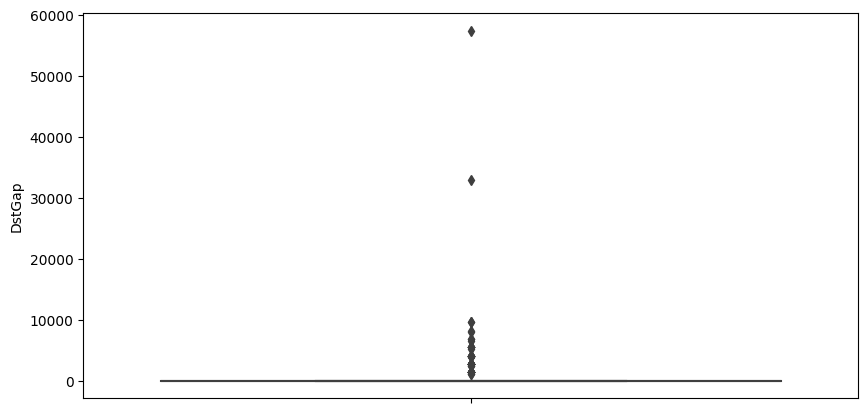

75th %ile 0.42403638573551516, Col name: DstGap 

25th %ile 0.0, Col name: DstGap 

IQR 0.42403638573551516, Col name: DstGap 

Upper limit 1.060090964338788, Col name: DstGap 

Lower limit -0.6360545786032727, Col name: DstGap 

outliers size: 140 

count      70.000000
mean     4581.742857
std      7593.668680
min      1083.000000
25%      1368.000000
50%      2736.000000
75%      4104.000000
max     57387.000000
Name: DstGap, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood    67
Benign        3
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 33 name: Rate 

Column dtype: float64 

Value Description: 

count    1215675.000000
mean         925.922655
std        85370.606086
min            0.000000
25%            0.000000
50%            0.000000
75%            0.388612
max     28000000.000000
Name: Rate, dtype: float64 



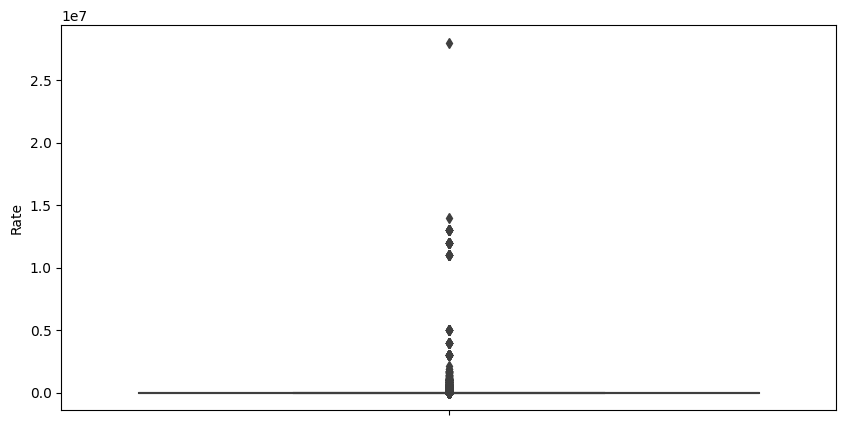

75th %ile 0.388612, Col name: Rate 

25th %ile 0.0, Col name: Rate 

IQR 0.388612, Col name: Rate 

Upper limit 0.97153, Col name: Rate 

Lower limit -0.582918, Col name: Rate 

outliers size: 366628 

count     183314.000000
mean        6139.572320
std       219774.064418
min            0.971650
25%            2.356792
50%            4.193886
75%           50.767221
max     28000000.000000
Name: Rate, dtype: float64

outliers - Attack Type counts: Attack Type
SlowrateDoS       67926
HTTPFlood         57305
Benign            48335
SYNFlood           8336
ICMPFlood          1154
TCPConnectScan      136
SYNScan              83
UDPScan              39
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 34 name: SrcRate 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean        237.991297
std       22371.539360
min           0.000000
25%           0.00000

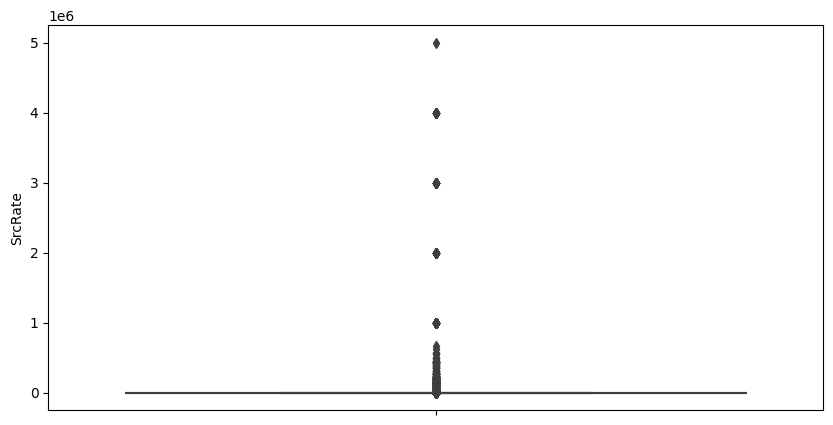

75th %ile 0.388341, Col name: SrcRate 

25th %ile 0.0, Col name: SrcRate 

IQR 0.388341, Col name: SrcRate 

Upper limit 0.9708524999999999, Col name: SrcRate 

Lower limit -0.5825115, Col name: SrcRate 

outliers size: 247136 

count    123568.000000
mean       2339.942709
std       70135.222323
min           0.970867
25%           1.428515
50%           2.495188
75%          39.969222
max     5000000.000000
Name: SrcRate, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         42790
Benign            37800
SlowrateDoS       34519
SYNFlood           8331
TCPConnectScan      106
SYNScan              22
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 35 name: DstRate 

Column dtype: float64 

Value Description: 

count    1215675.000000
mean         500.054576
std        56578.292272
min            0.000000
25%            0.000000
50%            0.00

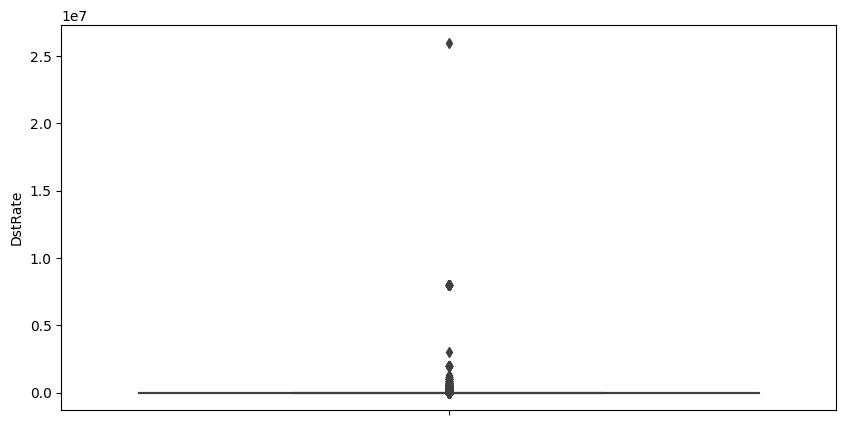

75th %ile 0.0, Col name: DstRate 

25th %ile 0.0, Col name: DstRate 

IQR 0.0, Col name: DstRate 

Upper limit 0.0, Col name: DstRate 

Lower limit 0.0, Col name: DstRate 

outliers size: 316098 

count     158049.000000
mean        3846.299863
std       156873.778837
min            0.200001
25%            0.966612
50%            1.847018
75%            4.527727
max     26000000.000000
Name: DstRate, dtype: float64

outliers - Attack Type counts: Attack Type
SlowrateDoS    66548
HTTPFlood      53675
Benign         37819
SYNFlood           7
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 36 name: SrcWin 

Column dtype: float64 

Value Description: 

count    1215675.000000
mean      915680.244717
std      2228990.979773
min            0.000000
25%       915680.244717
50%       915680.244717
75%       915681.012054
max     33553920.000000
Name: SrcWin, dtype: float64 



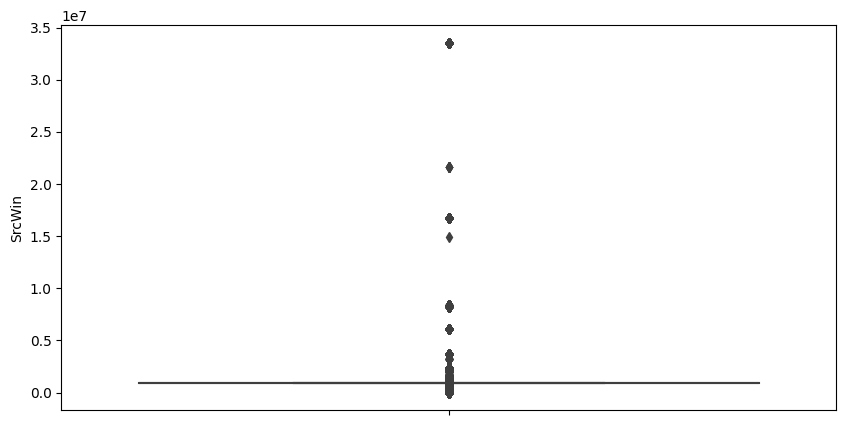

75th %ile 915681.0120541125, Col name: SrcWin 

25th %ile 915680.2447169409, Col name: SrcWin 

IQR 0.767337171593681, Col name: SrcWin 

Upper limit 915682.1630598699, Col name: SrcWin 

Lower limit 915679.0937111835, Col name: SrcWin 

outliers size: 634720 

count     317360.000000
mean      915679.183049
std      4362560.528988
min            0.000000
25%        56704.000000
50%        64128.000000
75%       852491.002331
max     33553920.000000
Name: SrcWin, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         140810
SlowrateDoS        73124
Benign             36549
TCPConnectScan     20052
SYNScan            20043
UDPScan            15906
SYNFlood            9721
ICMPFlood           1155
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 37 name: DstWin 

Column dtype: float64 

Value Description: 

count    1215675.000000
mean       74432.543

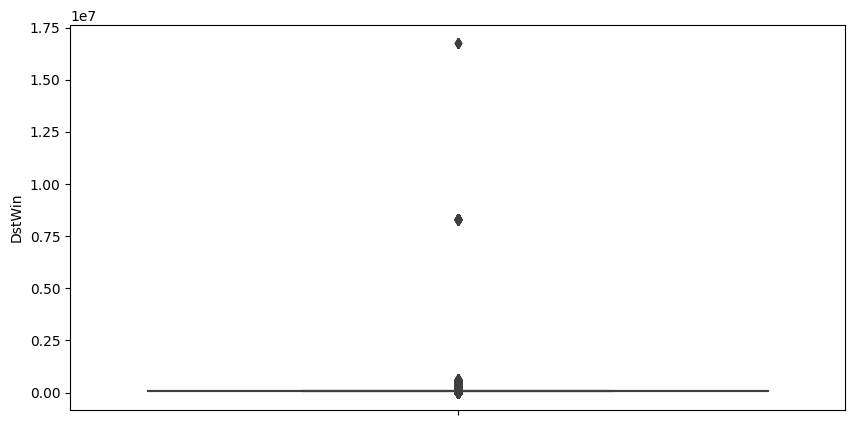

75th %ile 74432.54886859313, Col name: DstWin 

25th %ile 74432.54399498964, Col name: DstWin 

IQR 0.004873603495070711, Col name: DstWin 

Upper limit 74432.55617899838, Col name: DstWin 

Lower limit 74432.5366845844, Col name: DstWin 

outliers size: 634724 

count     317362.000000
mean       74432.537252
std       153407.298971
min            0.000000
25%        64896.000000
50%        65024.000000
75%        72824.012872
max     16776960.000000
Name: DstWin, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         140812
SlowrateDoS        73124
Benign             36549
TCPConnectScan     20052
SYNScan            20043
UDPScan            15906
SYNFlood            9721
ICMPFlood           1155
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 38 name: SrcTCPBase 

Column dtype: float64 

Value Description: 

count      1215675.000000
mean    2044

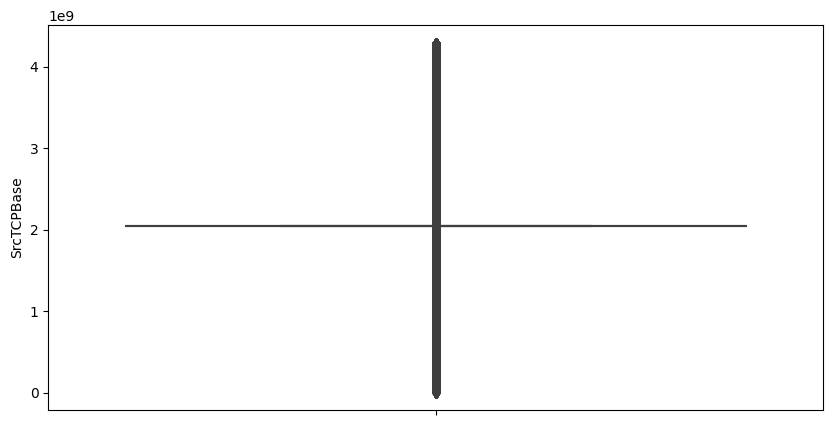

75th %ile 2044247683.028402, Col name: SrcTCPBase 

25th %ile 2044247683.0265203, Col name: SrcTCPBase 

IQR 0.0018818378448486328, Col name: SrcTCPBase 

Upper limit 2044247683.0312247, Col name: SrcTCPBase 

Lower limit 2044247683.0236974, Col name: SrcTCPBase 

outliers size: 634728 

count       317364.000000
mean    2044247683.023921
std     1155796107.933208
min         123073.000000
25%     1108675185.250000
50%     2044247683.018809
75%     2927058539.000000
max     4294967295.000000
Name: SrcTCPBase, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         140812
SlowrateDoS        73124
Benign             36551
TCPConnectScan     20052
SYNScan            20043
UDPScan            15906
SYNFlood            9721
ICMPFlood           1155
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 39 name: DstTCPBase 

Column dtype: float64 

Value Descript

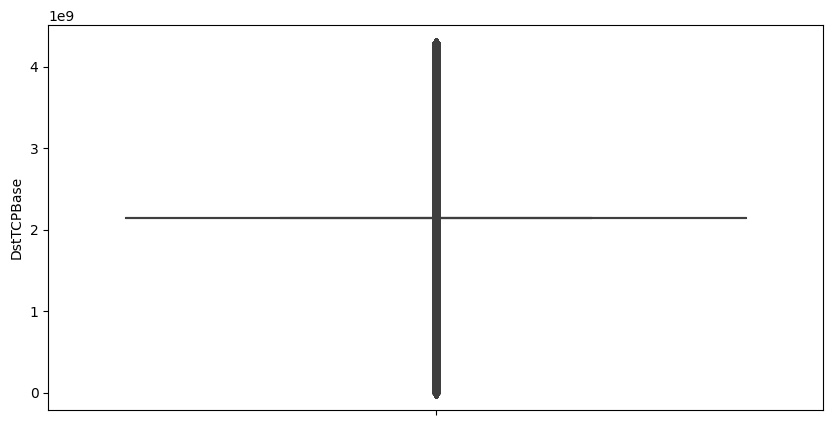

75th %ile 2145664155.7922304, Col name: DstTCPBase 

25th %ile 2145664155.7922084, Col name: DstTCPBase 

IQR 2.193450927734375e-05, Col name: DstTCPBase 

Upper limit 2145664155.7922633, Col name: DstTCPBase 

Lower limit 2145664155.7921755, Col name: DstTCPBase 

outliers size: 634728 

count       317364.000000
mean    2145664155.792262
std     1058581088.505301
min          33089.000000
25%     1479614298.250000
50%     2145664155.791982
75%     2813234223.000000
max     4294956058.000000
Name: DstTCPBase, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         140812
SlowrateDoS        73124
Benign             36551
TCPConnectScan     20052
SYNScan            20043
UDPScan            15906
SYNFlood            9721
ICMPFlood           1155
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 40 name: TcpRtt 

Column dtype: float64 

Value Description

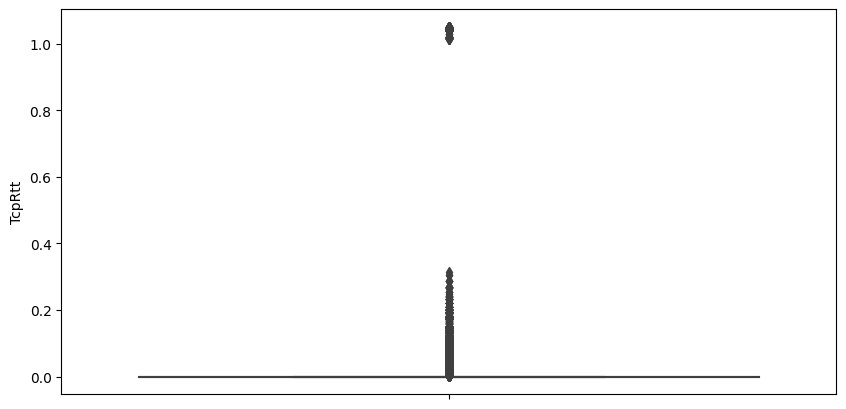

75th %ile 0.0, Col name: TcpRtt 

25th %ile 0.0, Col name: TcpRtt 

IQR 0.0, Col name: TcpRtt 

Upper limit 0.0, Col name: TcpRtt 

Lower limit 0.0, Col name: TcpRtt 

outliers size: 455176 

count   227588.000000
mean         0.024948
std          0.033419
min          0.001124
25%          0.014993
50%          0.020867
75%          0.027957
max          1.051236
Name: TcpRtt, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         140807
SlowrateDoS        72919
SYNFlood            8336
Benign              5443
TCPConnectScan        61
SYNScan               22
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 41 name: SynAck 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          0.000582
std           0.013057
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.024

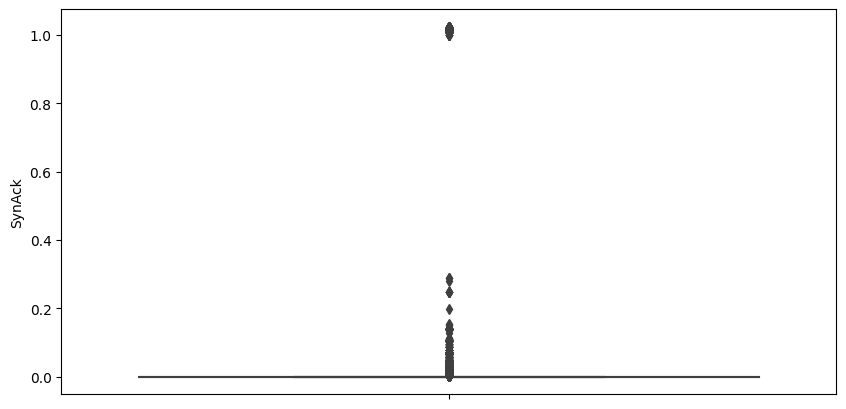

75th %ile 0.0, Col name: SynAck 

25th %ile 0.0, Col name: SynAck 

IQR 0.0, Col name: SynAck 

Upper limit 0.0, Col name: SynAck 

Lower limit 0.0, Col name: SynAck 

outliers size: 455176 

count   227588.000000
mean         0.003107
std          0.030046
min          0.000455
25%          0.001519
50%          0.001759
75%          0.002077
max          1.024680
Name: SynAck, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         140807
SlowrateDoS        72919
SYNFlood            8336
Benign              5443
TCPConnectScan        61
SYNScan               22
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------

Column 42 name: AckDat 

Column dtype: float64 

Value Description: 

count   1215675.000000
mean          0.004089
std           0.010537
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.266

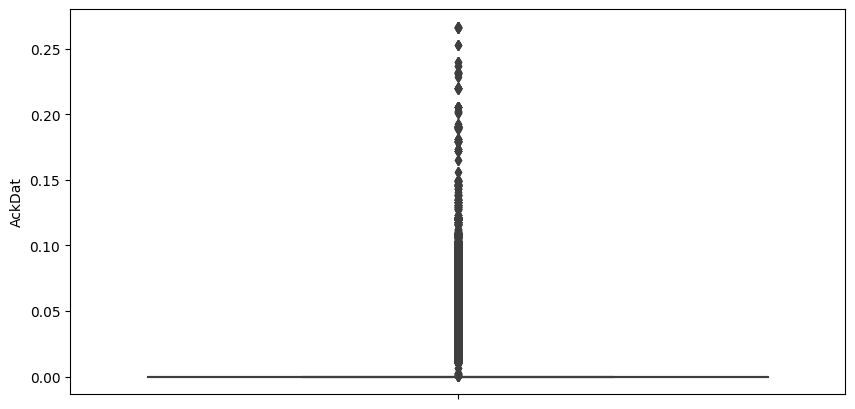

75th %ile 0.0, Col name: AckDat 

25th %ile 0.0, Col name: AckDat 

IQR 0.0, Col name: AckDat 

Upper limit 0.0, Col name: AckDat 

Lower limit 0.0, Col name: AckDat 

outliers size: 438448 

count   219224.000000
mean         0.022674
std          0.013937
min          0.000218
25%          0.013455
50%          0.019259
75%          0.026063
max          0.266729
Name: AckDat, dtype: float64

outliers - Attack Type counts: Attack Type
HTTPFlood         140804
SlowrateDoS        72919
Benign              5440
TCPConnectScan        61
Name: count, dtype: int64  


--------------------------------------------------------------


--------------------------------------------------------------



In [42]:
for i, col in enumerate(df.select_dtypes('number').columns):
    view_numeric_columns_distribution(i+1, col)